# **Task 2 - Balanced Random Network (Moderate)**

This task will create a "balanced random network" that is similar to part of the Cortex in the brain. It consists of two generic populations of excitatory (E) and inhibitory (I) neurons. Based on biological observations, there is a classical ratio of 4 excitatory neurons for 1 inhibitory neuron and a sparse, random reciprocal connectivity. The network generates a balanced regime where the average depolarization of the neurons is roughly constant, subthreshold, and an asynchronous irregular spiking is the result of fluctuations. Depending on certain key parameters, mainly the amount of external noise injected and the balance between E-I weights, several regimes of activity can be observed. Those regime have been described and classified in [Brunel, 2000], and can be asynchronous/synchronous (from a population viewpoint) or regular/irregular (from a neuron viewpoint).

In this implementation, we will take some input from outside of the network, representing the surrounding neurons, in the form of strongly-active Poisson spike sources. These will then feed into excitatory and inhibitory populations of LIF neurons, having a 4:1 ratio and set up in a balanced random fashion. We will use distributions of weights and delays as would occur in the brain.

**Run the following cell before you start!**


In [ ]:
# RUN THIS CELL
!pip install brian2
from brian2 import *

     |████████████████████████████████| 1.2MB 13.1MB/s 
     |████████████████████████████████| 5.8MB 52.0MB/s 
  Created wheel for brian2: filename=Brian2-2.4.2-cp36-cp36m-linux_x86_64.whl size=1257539 sha256=182ba74de2c4337a779011a9914112b1cea2a7a98db3ef8cb675ffcfff9db154
  Stored in directory: /root/.cache/pip/wheels/5d/4b/cf/ef50e71df5479d67f981cbb17b1d842381019d27ba144d57de
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


Create a variable containing the number of neurons to be simulated in the network and set this to 100. Then set up the simulation to use 0.1ms timesteps.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

N_neurons = 100
dt = 0.1 * ms
defaultclock.dt = dt

Create two input (stimulation) populations with Poisson spiking statistics having a mean firing rate of 1000Hz. The first population will be excitatory and should have 80% of the neurons, the second will be inhibitory and should have the remaining 20% of the neurons (hint: the number of neurons needs to be integers).

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

N_exc = int(N_neurons * 0.8)
N_inh = N_neurons - N_exc
Input_exc = PoissonGroup(N_exc, rates=1000 * Hz)
Input_inh = PoissonGroup(N_inh, rates=1000 * Hz)

Create two LIF populations: an excitatory population with 80% of the neurons and an inhibitory population with 20% of the neurons. Set the membrane time constant to 20ms, the synaptic time constant to 5ms, the refractory period to 2ms, the threshold to -50mV and the reset potential to -65mV.

You should then set a different resting potential for every neuron (<u>important hint</u>: to do so, you must first of all make the resting potential *u_rest* an internal variable of the populations by adding a new line in the definition of the LIF model where you specify its dimension with "u_rest  :  volt"). Create two arrays for storing the resting potentials of the neurons in the two poulations (e.g. *u_rest_exc* and *u_rest_inh*). These arrays will store values extracted from uniform distributions ranging from -65mV to -60mV (hint: use the function "*np.random.uniform*"). Initialize the membrane potential of the populations with such values and, finally, inform the populations of the resting values to use by calling their *u_rest* variable and setting it equal to the corresponding array (e.g. *Pop_exc.u_rest = u_rest_exc*).

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

tau_m = 20 * ms
tau_s = 5 * ms
tau_ref = 2 * ms
u_th = -50 * mV
u_reset = -65 * mV

u_rest_exc = np.random.uniform(low=-65, high=-60, size=N_exc) * mV
u_rest_inh = np.random.uniform(low=-65, high=-60, size=N_inh) * mV

model = '''
du/dt = - (u - u_rest - u_s) / tau_m   : volt  (unless refractory)
du_s/dt = - u_s / tau_s                : volt
u_rest                                 : volt
'''

Pop_exc = NeuronGroup(N=N_exc, model=model, threshold='u >= u_th',
                      reset='u = u_reset', method='euler', refractory=tau_ref)
Pop_exc.u = u_rest_exc
Pop_exc.u_rest = u_rest_exc

Pop_inh = NeuronGroup(N=N_inh, model=model, threshold='u >= u_th',
                      reset='u = u_reset', method='euler', refractory=tau_ref)
Pop_inh.u = u_rest_inh
Pop_inh.u_rest = u_rest_inh

Create a one-to-one excitatory connection from the excitatory Poisson input population to the excitatory LIF population, and a similar excitatory connection from the inhibitory Poisson population to the inhibitory LIF population. Set all the weights to 2.2mV and the delays to 1.0ms.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

Syn_ee_input = Synapses(Input_exc, Pop_exc,
                  model="""w : volt""", on_pre='u_s += w', delay=1. * ms)
Syn_ee_input.connect(j='i')
Syn_ee_input.w = 2.2 * mV

Syn_ii_input = Synapses(Input_inh, Pop_inh,
                  model="""w : volt""", on_pre='u_s += w', delay=1. * ms)
Syn_ii_input.connect(j='i')
Syn_ii_input.w = 2.2 * mV

Create two excitatory connections from the excitatory LIF population to itself (E-self) and to the inhibitory LIF population (E-I). Use:
 - a fixed probability of connection of 0.1
 - a normal distribution of positive weights with a mean of 0mV and a standard deviation of 2mV (hint: use the function "*np.random.normal*" and make all weights positive by applying the "*np.abs*" function)
 - a normal distribution of delays with a mean of 1.5ms and standard deviation of 0.75ms

Note that weights and delays must be different for every connection in the "*Synapses*" objects.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

Syn_e_self = Synapses(Pop_exc, Pop_exc,
                      model="""w : volt""", on_pre='u_s += w')
Syn_e_self.connect(p=0.1)
Syn_e_self.w = np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_e_self))) * mV
Syn_e_self.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_e_self)) * ms

Syn_ei = Synapses(Pop_exc, Pop_inh,
                  model="""w : volt""", on_pre='u_s += w')
Syn_ei.connect(p=0.1)
Syn_ei.w = np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_ei))) * mV
Syn_ei.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_ei)) * ms

Create two similar connections (with 0.1 probability) between the inhibitory LIF population and itself (I-self) and to the excitatory LIF population (I-E). Set weights and delays with same distributions as before, but make the weights negative (inhibitory) and four times bigger than before.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

Syn_i_self = Synapses(Pop_inh, Pop_inh,
                      model="""w : volt""", on_pre='u_s += w')
Syn_i_self.connect(p=0.1)
Syn_i_self.w = - 4 * np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_i_self))) * mV
Syn_i_self.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_i_self)) * ms

Syn_ie = Synapses(Pop_inh, Pop_exc,
                  model="""w : volt""", on_pre='u_s += w')
Syn_ie.connect(p=0.1)
Syn_ie.w = - 4 * np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_ie))) * mV
Syn_ie.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_ie)) * ms

If you wish, you may visualise the connectivity you have built by using the given function.

In [ ]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(12, 6))
    subplot(121)
    plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=8)
    plot(np.ones(Nt), np.arange(Nt), 'ok', ms=8)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    show()

# Write your code here

Record the spikes from the both excitatory and inhibitory populations.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

Mon_spikes_exc = SpikeMonitor(Pop_exc)
Mon_spikes_inh = SpikeMonitor(Pop_inh)

Build the network adding all the elements.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

net = Network(Input_exc, Input_inh, Pop_exc, Pop_inh,
              Syn_ee_input, Syn_ii_input, Syn_e_self, Syn_ei, Syn_i_self, Syn_ie,
              Mon_spikes_exc, Mon_spikes_inh)

Run the simulation for 1 second.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

T = 1000 * ms
net.run(T, report='stdout')

WARNING    "dt" is an internal variable of group "poissongroup_1", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


Retrieve spikes and visualise a rasterplot of the spiking activity. Distinguish between spikes from the excitatory and inhibitory populations.

In [ ]:
# Write your code here

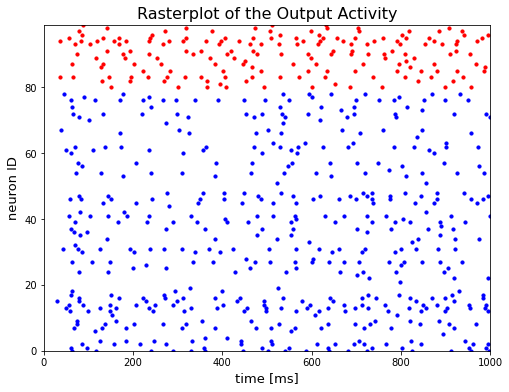

In [ ]:
#@title Double-click here for solution

N = int(round(T/dt))
times = np.linspace(0, T / ms, N, endpoint=False)
spike_times_exc = Mon_spikes_exc.t / ms
spike_id_exc = Mon_spikes_exc.i
spike_times_inh = Mon_spikes_inh.t / ms
spike_id_inh = Mon_spikes_inh.i

figure(figsize=(8, 6))
scatter(spike_times_exc, spike_id_exc, c='blue', s=10)
scatter(spike_times_inh, spike_id_inh + N_exc, c='red', s=10)
xlabel('time [ms]', fontsize=13)
ylabel('neuron ID', fontsize=13)
ylim(0, N_neurons - 1)
xlim(0, T / ms)
title('Rasterplot of the Output Activity', fontsize=16)
show()

The graph should show what is known as *asynchronous irregular spiking activity*, this means that the neurons in the population don’t spike very often, and when they do it is not at the same time as other neurons in the population.



---

#### **Extension**

Try adding an additional population of 100 neurons that stimulates the E population with 50Hz Poisson noise using an all-to-all connector, and a weight of 0.06mV. See what other behavior you can get by trying to alter the rate of this new population.

In [ ]:
# Write your code here

In [ ]:
#@title Double-click here for solution

# ---------------- 1. Establish the time-step of the simulation ----------------
dt = 0.1 * ms
defaultclock.dt = dt

# ---------------------- 2. Create the neural populations ----------------------
N_neurons = 100
N_exc = int(N_neurons * 0.8)
N_inh = N_neurons - N_exc
tau_m = 20 * ms
tau_s = 5 * ms
tau_ref = 2 * ms
u_th = -50 * mV
u_reset = -65 * mV
model = '''
du/dt = - (u - u_rest - u_s) / tau_m   : volt  (unless refractory)
du_s/dt = - u_s / tau_s                : volt
u_rest                                 : volt
'''

u_rest_exc = np.random.uniform(low=-65, high=-60, size=N_exc) * mV
u_rest_inh = np.random.uniform(low=-65, high=-60, size=N_inh) * mV

Pop_exc = NeuronGroup(N=N_exc, model=model, threshold='u >= u_th',
                      reset='u = u_reset', method='euler', refractory=tau_ref)
Pop_exc.u = u_rest_exc
Pop_exc.u_rest = u_rest_exc
Pop_inh = NeuronGroup(N=N_inh, model=model, threshold='u >= u_th',
                      reset='u = u_reset', method='euler', refractory=tau_ref)

Pop_inh.u = u_rest_inh
Pop_inh.u_rest = u_rest_inh
Input_exc = PoissonGroup(N_exc, rates=1000 * Hz)
Input_inh = PoissonGroup(N_inh, rates=1000 * Hz)

# Add the new population
Pop_new = PoissonGroup(N_neurons, rates=50 * Hz)

# --------------------------- 3. Create the synapses ---------------------------
Syn_ee_input = Synapses(Input_exc, Pop_exc,
                  model="""w : volt""", on_pre='u_s += w', delay=1. * ms)
Syn_ee_input.connect(j='i')
Syn_ee_input.w = 2.2 * mV

Syn_ii_input = Synapses(Input_inh, Pop_inh,
                  model="""w : volt""", on_pre='u_s += w', delay=1. * ms)
Syn_ii_input.connect(j='i')
Syn_ii_input.w = 2.2 * mV

Syn_e_self = Synapses(Pop_exc, Pop_exc,
                      model="""w : volt""", on_pre='u_s += w')
Syn_e_self.connect(p=0.1)
Syn_e_self.w = np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_e_self))) * mV
Syn_e_self.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_e_self)) * ms

Syn_ei = Synapses(Pop_exc, Pop_inh,
                  model="""w : volt""", on_pre='u_s += w')
Syn_ei.connect(p=0.1)
Syn_ei.w = np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_ei))) * mV
Syn_ei.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_ei)) * ms

Syn_i_self = Synapses(Pop_inh, Pop_inh,
                      model="""w : volt""", on_pre='u_s += w')
Syn_i_self.connect(p=0.1)
Syn_i_self.w = - 4 * np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_i_self))) * mV
Syn_i_self.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_i_self)) * ms

Syn_ie = Synapses(Pop_inh, Pop_exc,
                  model="""w : volt""", on_pre='u_s += w')
Syn_ie.connect(p=0.1)
Syn_ie.w = - 4 * np.abs(np.random.normal(loc=0, scale=2, size=len(Syn_ie))) * mV
Syn_ie.delay = np.random.normal(loc=1.5, scale=.75, size=len(Syn_ie)) * ms

# Add the new synapse
Syn_new = Synapses(Pop_new, Pop_exc,
                   model="""w : volt""", on_pre='u_s += w')
Syn_new.connect()
Syn_new.w = 0.06 * mV

# -------------------------- 4. Setup data monitoring --------------------------
Mon_spikes_exc = SpikeMonitor(Pop_exc)
Mon_spikes_inh = SpikeMonitor(Pop_inh)


# -------------------- 5. Build and feed the network object --------------------

# Add the new elements to the network
net = Network(Input_exc, Input_inh, Pop_exc, Pop_inh, Pop_new, Mon_spikes_exc, Mon_spikes_inh,
              Syn_ee_input, Syn_ii_input, Syn_e_self, Syn_ei, Syn_i_self, Syn_ie, Syn_new)

# --------------------------- 6. Run the simulation ----------------------------
T = 1000 * ms
net.run(T, report='stdout')

# ------------------ 7. Retrieve and plot the recorded data --------------------
N = int(round(T/dt))
times = np.linspace(0, T / ms, N, endpoint=False)
spike_times_exc = Mon_spikes_exc.t / ms
spike_id_exc = Mon_spikes_exc.i
spike_times_inh = Mon_spikes_inh.t / ms
spike_id_inh = Mon_spikes_inh.i

figure(figsize=(8, 6))
scatter(spike_times_exc, spike_id_exc, c='blue', s=10)
scatter(spike_times_inh, spike_id_inh + N_exc, c='red', s=10)
xlabel('time [ms]', fontsize=13)
ylabel('neuron ID', fontsize=13)
ylim(0, N_neurons - 1)
xlim(0, T / ms)
title('Rasterplot of the Output Activity', fontsize=16)
show()